# BI-PRS - Semestral work 3

## Dataset selection according to the represant's data

In [47]:
K <- 27
L <- nchar('bardatskii')
M <- ((K + L) * 47) %% 11 + 1

cat('Parameter M =', M, '=> Kamil Dedecius')
cat('\nYear =', 2011 + M)

Parameter M = 2 => Kamil Dedecius
Year = 2013

## Necessary imports

In [48]:
# TODO: lexicographical order
library(eurostat)
library(countrycode)
library(stringr)
library(ggplot2)
library(psych)

## Data preparation

### Target variable

In [49]:
data <- get_eurostat(id='nama_10_pc')

Dataset query already saved in cache_list.json...

Reading cache file /tmp/RtmpSP7xDT/eurostat/e911d1aa08195ff09858b9c05f37f28b.rds

Table  nama_10_pc  read from cache file:  /tmp/RtmpSP7xDT/eurostat/e911d1aa08195ff09858b9c05f37f28b.rds



We are only interested in the **Gross Domestic Product per capita** in euros of individual European countries based on $2013$ results, so we remove everything unnecessary.

Also the names of countries and columns are renamed for better readability.

In [50]:
colnames(data)[4] <- 'country'  # rename "geo" column
colnames(data)[6] <- 'GDPpc'  # rename "values" column
data <- subset(data,
               na_item == 'B1GQ' &  # Gross domestic product at market prices
               unit == 'CP_EUR_HAB' &  # Current prices, euro per capita
               TIME_PERIOD == '2013-01-01' &
               !(country %in% c(
                   'EU27_2020',  # European Union - 27 countries (from 2020)
                   'EU28',  # European Union - 28 countries (2013-2020)
                   'EU15',  # European Union - 15 countries (1995-2004)
                   'EA',  # Euro area
                   'EA20',  # Euro area – 20 countries (from 2023)
                   'EA19',  # Euro area - 19 countries  (2015-2022)
                   'EA12'  # Euro area - 12 countries (2001-2006)
               )),
               c(country, GDPpc))
data$country <- countrycode(data$country, 'eurostat', 'country.name')
data$country <- factor(data$country)

In [51]:
any(is.na(data$GDPpc))  # no NA values

[1] FALSE

In [52]:
str(data)

tibble [37 × 2] (S3: tbl_df/tbl/data.frame)
 $ country: Factor w/ 37 levels "Albania","Austria",..: 1 2 3 4 35 6 7 12 8 9 ...
 $ GDPpc  : num [1:37] 3320 38210 35210 5790 65730 ...


In [53]:
head(data)

country,GDPpc
<fct>,<dbl>
Albania,3320
Austria,38210
Belgium,35210
Bulgaria,5790
Switzerland,65730
Cyprus,20930


Now let's take a look at the target variable.

In [54]:
describe(data$GDPpc, ranges=F, quant=c(0.25, 0.5, 0.75), IQR=T)[, -1]

,n,mean,sd,skew,kurtosis,se,IQR,Q0.25,Q0.5,Q0.75
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
X1,37,28581.89,26472.6,1.872638,3.834095,4352.069,27700,10480,18680,38180


Skewness and the strong deviation of the mean from the median indicate the presence of an “eastern” tail in the distribution. Let's check it out on the histogram.

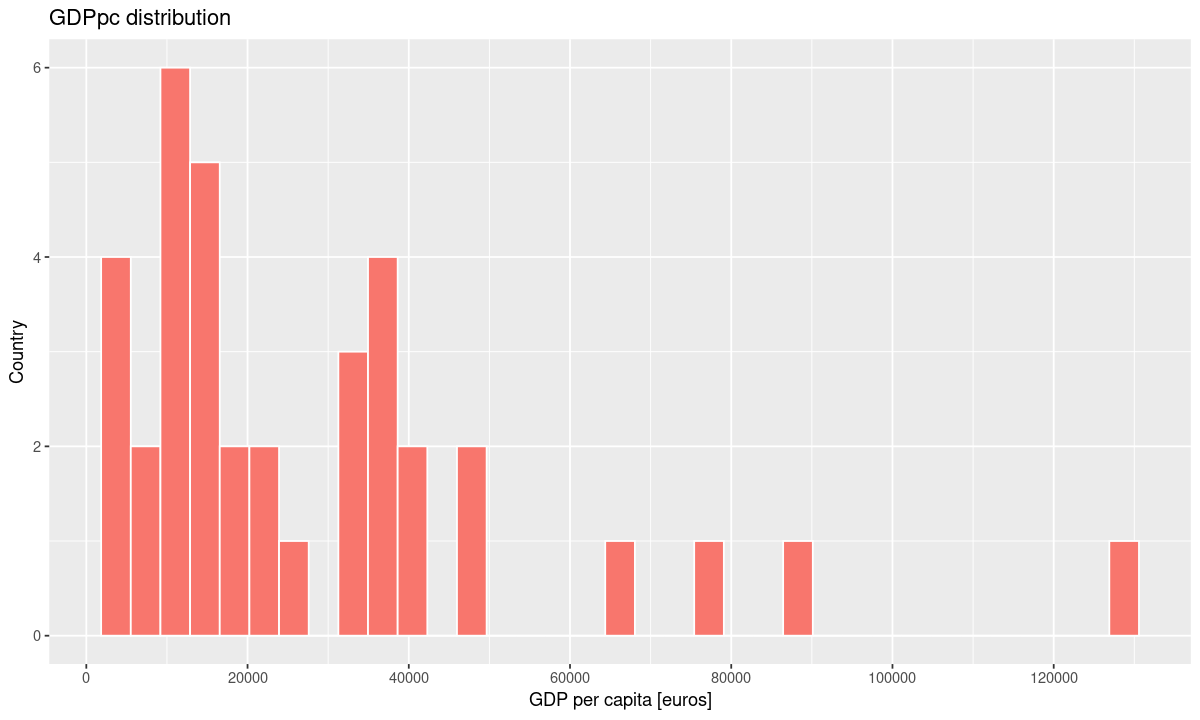

In [55]:
ggplot(data, aes(x=GDPpc)) +
  geom_histogram(bins=35, fill='#f8766d', col='white') +
  labs(title='GDPpc distribution',
       x='GDP per capita [euros]',
       y='Country') + 
  scale_x_continuous(breaks=scales::pretty_breaks(n=6))

As expected, the distribution has a tail. Several countries have a much higher GDPpc than the rest.

In addition, three potential clusters can be noticed in the graph: 

1. $\mathrm{GDPpc} \le 30000$,
2. $30000 < \mathrm{GDPpc} \le 60000$,
3. $60000 < \mathrm{GDPpc}$.

Each of these clusters may be amenable to its own distribution. Below we will see an illustrative confirmation of this conjecture.

### Regressors selection

There are many factors that can affect the GDP per capita and the economy of a country in general. Below we propose three variants of a continuous variable and one binary. Let's take a look at them.

#### Continuous regressors

The [Human Development Report](https://en.wikipedia.org/wiki/Human_Development_Report), available at [this](https://hdr.undp.org/data-center/documentation-and-downloads) link, was used as the data source.



In [56]:
extra_src_url <- 'https://hdr.undp.org/sites/default/files/2023-24_HDR/HDR23-24_Composite_indices_complete_time_series.csv'

In [57]:
extra_data <- read.csv(url(extra_src_url), encoding='UTF-8')
extra_data$country <- str_replace(extra_data$country, 'T\xfcrkiye', 'Turkey')
all(data$country %in% extra_data$country)  # is subset

[1] TRUE

In [58]:
extra_data <- subset(extra_data,
       country %in% data$country,
       c(
           'country',
           'le_2013',  # Life Expectancy at Birth [years] ~ LE
           'mys_2013',  # Mean Years of Schooling [years] ~ MYS
           'eys_2013',  # Expected Years of Schooling [years] ~ EYS
           'gnipc_2013'  # Gross National Income Per Capita [2017 PPP$] ~ GNIpc
       ))

In [59]:
any(is.na(extra_data))  # no NA values

[1] FALSE

In [60]:
data <- merge(data, extra_data, by='country')

The indicators in one way or another related to the [Human Development Index](https://en.wikipedia.org/wiki/Human_Development_Index) were taken as a basis.

First of all, let's look at how HDI is calculated:

1. **Life Expectancy Index**: $\mathrm{LEI} = \frac{\mathrm{LE} - 20}{65}$
2. **Education Index**: $\mathrm{EI} = \frac{\frac{\mathrm{MYS}}{15} + \frac{\mathrm{EYS}}{18}}{2}$
3. **Income Index**: $\mathrm{II} = \frac{\ln(\mathrm{GNIpc}) - \ln(100)}{\ln(750)}$
4. **Human Development Index**: $\mathrm{HDI} = \sqrt[3]{\mathrm{LEI} \cdot \mathrm{EI} \cdot \mathrm{II}}$

Instead of using HDI itself, we take its components. However, just taking the presented indexes is not a good idea. Let's see why.

The problem with using LEI is that its values are much more difficult to interpret than LE values. As a consequence, we leave LE untouched.

GNIpc is calculated using the following formula$$\mathrm{GNIpc} = \mathrm{GDPpc} + \mathrm{NFIApc},$$where NFIApc is **Net Income from Abroad per capita** and is calculated as$$\mathrm{NFIApc} = \frac{\text{Money flowing from foreign countries} - \text{Money flowing to foreign countries}}{\text{Population}}.$$

Since GNIpc already contains GDPpc, using it would mean that our model would implicitly learn to predict NFIApc. This is not quite the right approach to the problem at hand. Therefore, we only take NFIApc as a regressor. However, we cannot simply subtract euro GDPpc from dollar GNIpc, we need to convert GNIpc into euros beforehand. For this purpose we use [this](https://www.exchangerates.org.uk/EUR-USD-spot-exchange-rates-history-2013.html#:~:text=Average%20exchange%20rate%20in%202013%3A%201.3284%20USD.) exchange rate.

In [61]:
data$LE <- data$le_2013
data$EI <- (data$mys_2013 / 15 + data$eys_2013 / 18) / 2
data$NFIApc <- data$gnipc_2013 / 1.3284 - data$GDPpc
data <- data[, c('country', 'GDPpc', 'LE', 'EI', 'NFIApc')]

#### Binary factor

The factor of the country's entry into the [Blue Banana](https://en.wikipedia.org/wiki/Blue_Banana) area was chosen as a binary predictor. The intuition behind this decision is based on the fact that the cities within this zone are of great economic importance.

Here's a [link](https://en.wikipedia.org/wiki/Blue_Banana) to the data source.

In [62]:
data$BB_entry <- (data$country %in% c(
    'Austria',
    'Belgium',
    'France',
    'Germany',
    'Italy',
    'Luxembourg',
    'Netherlands',
    'United Kingdom',
    'Liechtenstein',
    'Switzerland'
))

The final data is as follows.

In [63]:
head(data)

,country,GDPpc,LE,EI,NFIApc,BB_entry
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>
1,Albania,3320,78.123,0.7781896,5376.903,FALSE
2,Austria,38210,81.078,0.8383914,1791.626,TRUE
3,Belgium,35210,80.468,0.9221770,1962.076,TRUE
4,Bulgaria,5790,74.849,0.7824033,8144.946,FALSE
5,Croatia,10480,77.843,0.8044435,7332.921,FALSE
6,Cyprus,20930,80.402,0.7898399,3978.334,FALSE


## Data Visualization

In [64]:
# TODO: sapromak
# TODO: titles, labels, ...

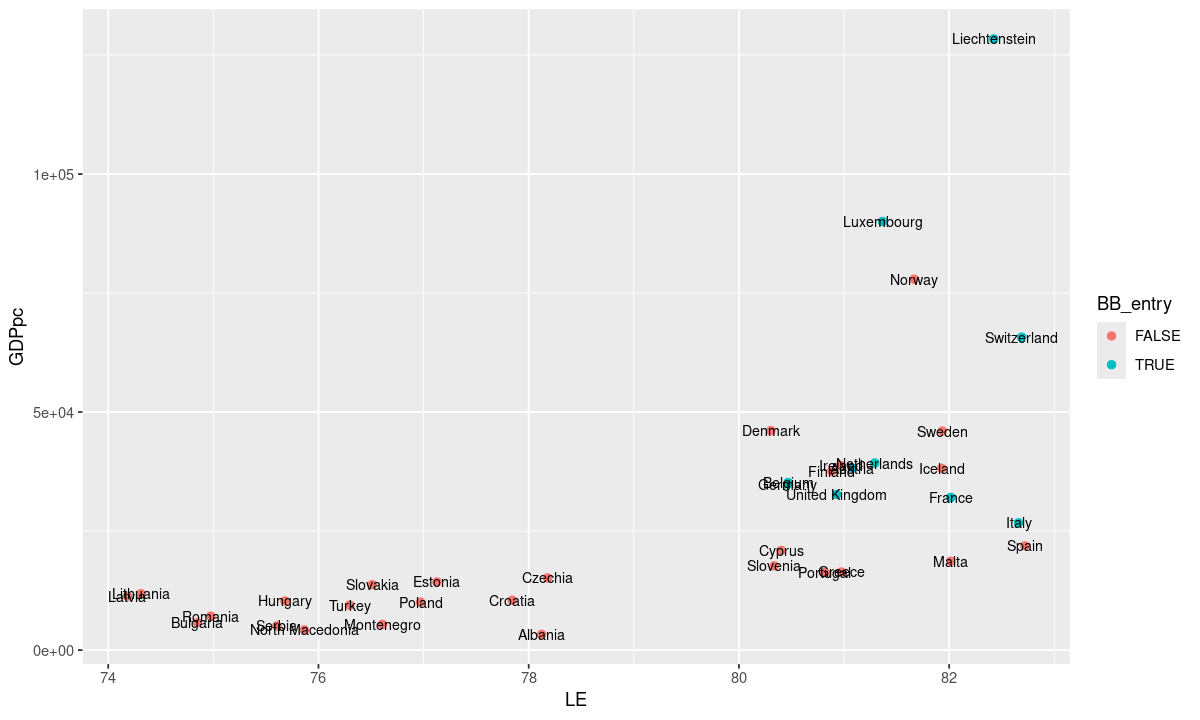

In [65]:
ggplot(data, aes(x=LE, y=GDPpc)) +
  geom_point(aes(col=BB_entry), size=2) +
  geom_text(aes(label=country), size=3)

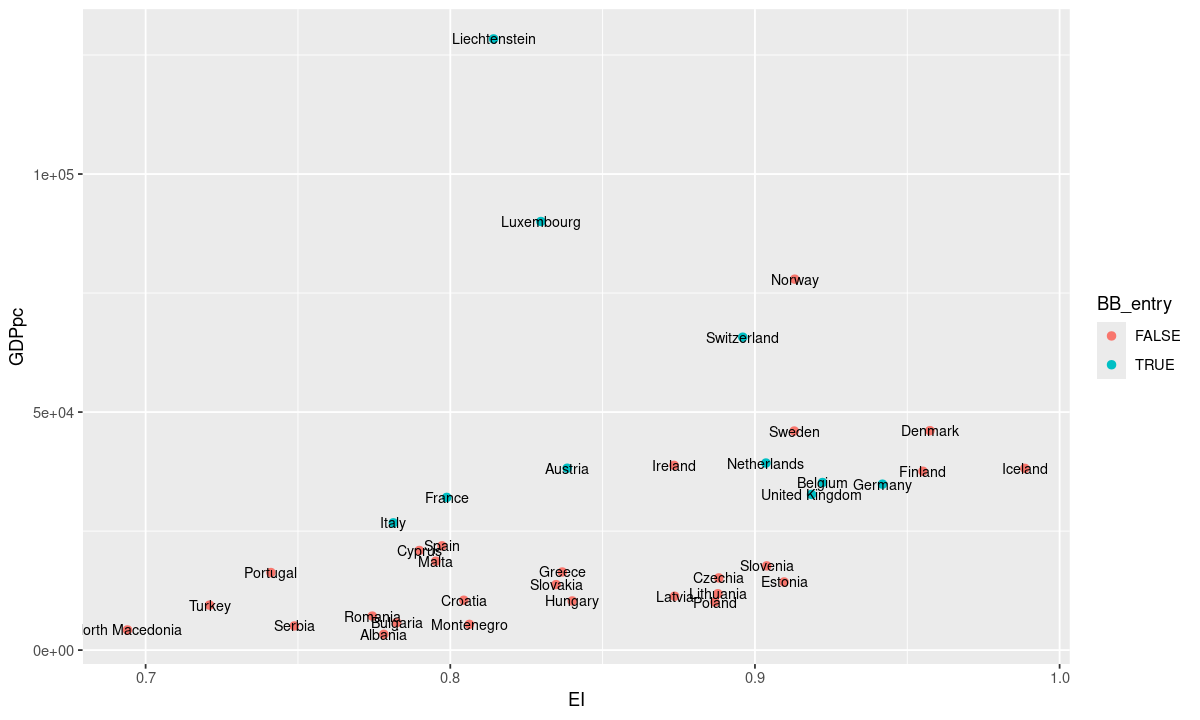

In [66]:
ggplot(data, aes(x=EI, y=GDPpc)) +
  geom_point(aes(col=BB_entry), size=2) +
  geom_text(aes(label=country), size=3)

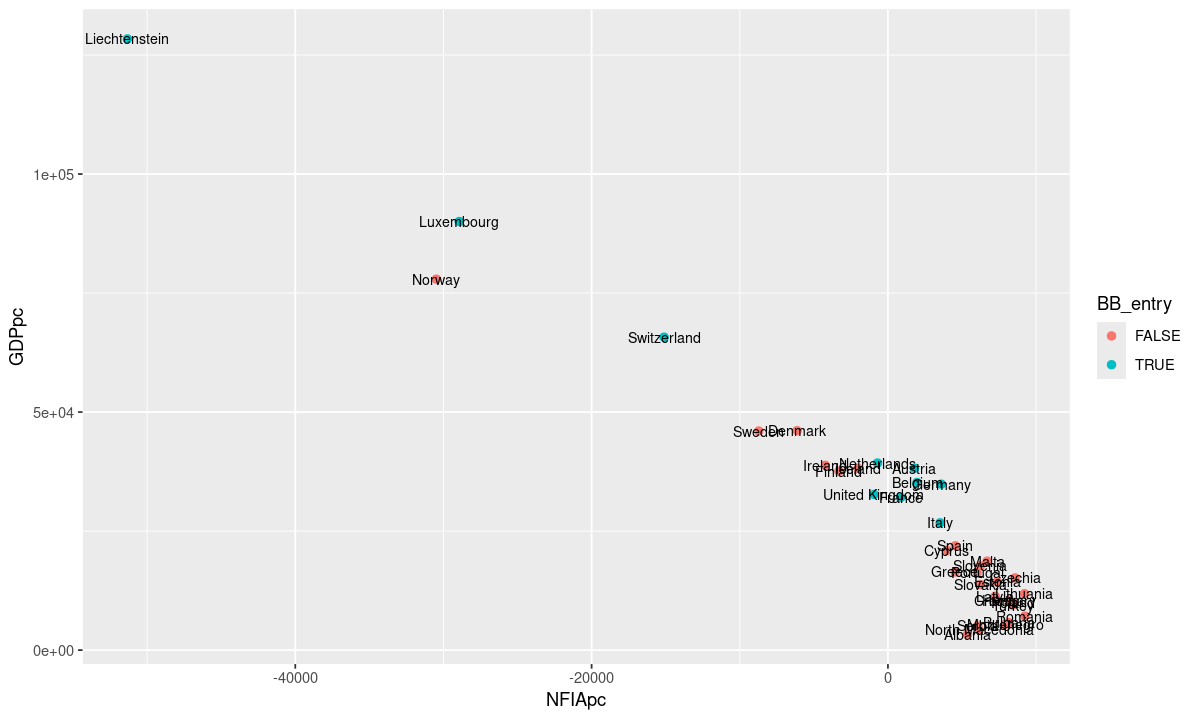

In [67]:
ggplot(data, aes(x=NFIApc, y=GDPpc)) +
  geom_point(aes(col=BB_entry), size=2) +
  geom_text(aes(label=country), size=3)

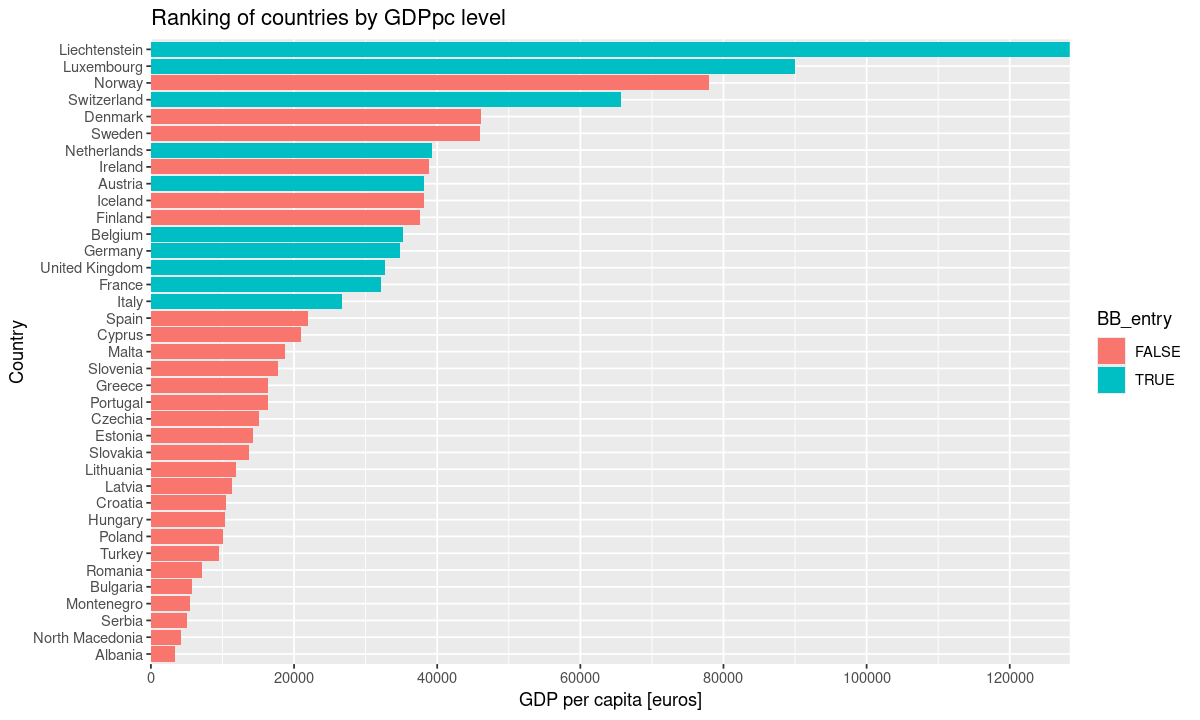

In [68]:
options(repr.plot.width=10, repr.plot.height=6)
ggplot(data, aes(x=GDPpc, y=reorder(country, GDPpc), fill=BB_entry)) +
  geom_bar(stat='identity') +
  labs(title='Ranking of countries by GDPpc level',
       x='GDP per capita [euros]',
       y='Country') +
  scale_x_continuous(breaks=scales::pretty_breaks(n=6), expand=c(0, 0))

In [69]:
cor(data[, -1])

,GDPpc,LE,EI,NFIApc,BB_entry
GDPpc,1.0000000,0.6311920,0.3253231,-0.9686997,0.5533379
LE,0.6311920,1.0000000,0.3055760,-0.5237608,0.5026726
EI,0.3253231,0.3055760,1.0000000,-0.2065396,0.1497472
NFIApc,-0.9686997,-0.5237608,-0.2065396,1.0000000,-0.4195419
BB_entry,0.5533379,0.5026726,0.1497472,-0.4195419,1.0000000
